# imports

# input data

In [5]:
# funtions to preprocess data
def mapping_2_df(actual_df,predicted_df,hit_threadhold = 0.5):
    result = pd.merge(actual_df,predicted_df, on=['video_id','action_id'],how='left',suffixes=('_g', '_p'))
    result['diff_start'] = abs(result['start_g']-result['start_p'])
    result['diff_end'] = abs(result['end_g']-result['end_p'])
    # filter out condition
    result['is_filtered'] = (result['diff_start'] >10) | (result['diff_end']>10)
    # calculate intersection time
    result['i_start'] = np.where(~result['is_filtered'], result[['start_g', 'start_p']].max(axis=1), np.nan)
    result['i_end'] = np.where(~result['is_filtered'], result[['end_g', 'end_p']].min(axis=1), np.nan)
    # calculate union time
    result['u_start'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['start_g', 'start_p']].min(axis=1), np.nan)
    result['u_end'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['end_g', 'end_p']].max(axis=1), np.nan)
    # calculate IoU
    result['intersection'] = result['i_end'] - result['i_start']
    result['union'] = result['u_end'] - result['u_start']
    result['iou'] = np.where(~result['is_filtered'] 
                             & result['union']>0,result['intersection']/result['union'],0)
    # flag hit base on threadhold
    result['is_hit'] = np.where(result['iou'] >= hit_threadhold,1,0)
    return result





In [6]:
# mapping df base on video_id and start
def mapping_2_df_by_time(actual_df,predicted_df,hit_threadhold = 0.5,time_threadhold = 10):
    '''
        mapping 2 df by video_id
            after that, add filter column with gap 10s from the contest
            calculate iou
            remap with actual_df for confusion_matrix
            relabel
        
    '''
    result = pd.merge(actual_df,predicted_df, on=['video_id'],how='left',suffixes=('_g', '_p'))
    result['diff_start'] = abs(result['start_g']-result['start_p'])
    result['diff_end'] = abs(result['end_g']-result['end_p'])

    # filter out condition
    result['is_filtered'] = (result['diff_start'] >time_threadhold) | (result['diff_end']>time_threadhold)
    result = result.loc[~result['is_filtered']]

    # calculate intersection time
    result['i_start'] = np.where(~result['is_filtered'], result[['start_g', 'start_p']].max(axis=1), np.nan)
    result['i_end'] = np.where(~result['is_filtered'], result[['end_g', 'end_p']].min(axis=1), np.nan)

    # calculate union time
    result['u_start'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['start_g', 'start_p']].min(axis=1), np.nan)
    result['u_end'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['end_g', 'end_p']].max(axis=1), np.nan)
    # calculate IoU
    result['intersection'] = result['i_end'] - result['i_start']
    result['union'] = result['u_end'] - result['u_start']
    result['iou'] = np.where(~result['is_filtered'] 
                             & result['union']>0,result['intersection']/result['union'],0)
    
    # flag hit base on threadhold
    result['is_hit'] = np.where(result['iou'] >= hit_threadhold,1,0)
    result = result.sort_values(['iou'],ascending=False).drop_duplicates(['video_id','action_id_p'])
    # result = result.loc[result['is_hit']==1]

    # remap with actual df
    temp = actual_df[['video_id','action_id']]\
            .merge(
                result[['video_id','action_id_g','action_id_p','iou']]                    
                ,left_on =['video_id','action_id']
                ,right_on=['video_id','action_id_g']
                ,how='left'
                ,suffixes=('_g', '_p'))
    temp['action_id_p'] = temp['action_id_p'].fillna(-1)
    action_label = pd.read_csv("data/Distracted_Activity_Class_definition.txt",sep=',')

    action_id_to_label = action_label.set_index('action_id')['Label'].to_dict()
    # display(action_label)
    # Map action_ids to labels in the DataFrame
    temp['action_label_g'] = temp['action_id'].map(action_id_to_label)
    temp['action_label_p'] = temp['action_id_p'].map(action_id_to_label)
    temp['action_label_g'] = temp['action_label_g'].fillna("-1")
    temp['action_label_p'] = temp['action_label_p'].fillna("-1")
    temp['iou'] = temp['iou'].fillna(0)
    return temp



# calculate and plot the confustion matrix

In [7]:


def cal_cm(y_true, y_pred):
    # add unreconized label 
    unique_labels = np.append(y_true.unique(), "-1")
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    # Convert to DataFrame for easier plotting
    # pd_df of indexes for columns and labels
    cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

    return cm_df

def plot_confusion_matrices(confusion_matrices_dict,size=25):
    fortmat_code = {'cm_count':'d','cm_iou':'.2f','action_iou':'.2f'}
    num_matrices = len(confusion_matrices_dict)
    # Extracting the keys from the dictionary and getting the number of metrics
    metrics = list(confusion_matrices_dict.values())[0].keys()
    num_metrics = len(metrics)

    # Create a figure with subplots based on the number of confusion matrices
    fig, axes = plt.subplots(num_matrices, num_metrics, figsize=(size * num_metrics+5, size * num_matrices+5))
    
    # If there's only one confusion matrix, make sure axes is a list
    if num_matrices == 1:
        axes = [axes]

    # Plot each confusion matrix
    for i, (title, metric_dict) in enumerate(confusion_matrices_dict.items()):
        for j, (metric_name, cm_df) in enumerate(metric_dict.items()):
            cm_df.sort_index(axis=0, inplace=True)
            cm_df.sort_index(axis=1, inplace=True)
            sns.heatmap(cm_df, annot=True, ax=axes[i, j], fmt=fortmat_code[metric_name], cmap='Blues',
                        xticklabels=cm_df.columns, yticklabels=cm_df.index)
            axes[i, j].set_title(f"{title} - {metric_name}",fontsize=size*1.5,fontweight='bold',color='blue')
            axes[i, j].set_ylabel('True label',fontsize=size,fontweight='bold')
            axes[i, j].set_xlabel('Predicted label',fontsize=size,fontweight='bold')
            axes[i, j].tick_params(axis='x', labelsize=size*0.5)
            axes[i, j].tick_params(axis='y', labelsize=size*0.5)
    # Show the plot
    plt.show()


def benchmark_submit(df_ground_truth, csv_file_path = 'A2_submission_old.txt'):
    print("*"*100)
    print(csv_file_path)
    print("*"*100)
    df_baseline = pd.read_csv(csv_file_path,sep=' ')
    df_baseline.columns = ['video_id', 'action_id','start','end']

    print("calculated result vs ground truth:") 
    preprocess = mapping_2_df(df_ground_truth,df_baseline)
    # display(preprocess)
    print("avg iou with correct action_id: ",preprocess['iou'].mean())
    print(f"hit = {preprocess['is_hit'].sum()} | count = {preprocess['is_hit'].count()} | hit/count = {preprocess['is_hit'].sum()/preprocess['is_hit'].count()}")
    action_label = pd.read_csv("data/Distracted_Activity_Class_definition.txt",sep=',')
    action_id_to_label = action_label.set_index('action_id')['Label'].to_dict()
    preprocess['action_label'] = preprocess['action_id'].map(action_id_to_label)
    display(pd.pivot_table(preprocess,values='iou',columns='action_label',aggfunc='mean',fill_value=0))
    print("Creating confusion matrix")
    test = mapping_2_df_by_time(df_ground_truth,df_baseline)
    # print(test.groupby('video_id').nunique())
    # display(test)
    result = {}
    
    result['cm_count'] = cal_cm(test['action_label_g'],test['action_label_p'])
    # result['iou'] = test['iou']
    result['cm_iou'] = pd.pivot_table(test,values='iou',index='action_label_g',columns='action_label_p',aggfunc='mean',fill_value=0)
    # Create a new DataFrame for the row to be added
    new_row = pd.DataFrame(data={col: [0] for col in result['cm_iou'].columns}, index=['-1'])
    # Append the new row to the pivot table
    result['cm_iou'] = pd.concat([result['cm_iou'], new_row])
    # overall action recognigtion iou (only consider correct action)
    result['action_iou'] = pd.pivot_table(preprocess,values='iou',index='action_label',aggfunc='mean',fill_value=0)
    print('Done')
    return result

****************************************************************************************************
A2_submission_baseline_test.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.7014440212099974
hit = 128 | count = 150 | hit/count = 0.8533333333333334


action_label,01.Drinking,02.Phone (right),03.Phone (left),04.Eating,05.Text (Right),06.Text (Left),07.Reaching behind,08.Adjust panel,09.Pick up (Driver),10.Pick up (Passenger),11.Talk right,12.Talk backseat,13.yawning,14.Hand on head,15.Singing or dancing
iou,0.690635,0.684979,0.859458,0.599342,0.713322,0.77861,0.77938,0.739402,0.643561,0.777143,0.617078,0.52095,0.47177,0.841715,0.804316


Creating confusion matrix
Done
****************************************************************************************************
final_submission_right.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.6613901346080459
hit = 121 | count = 150 | hit/count = 0.8066666666666666


action_label,01.Drinking,02.Phone (right),03.Phone (left),04.Eating,05.Text (Right),06.Text (Left),07.Reaching behind,08.Adjust panel,09.Pick up (Driver),10.Pick up (Passenger),11.Talk right,12.Talk backseat,13.yawning,14.Hand on head,15.Singing or dancing
iou,0.581111,0.694702,0.679892,0.66868,0.745037,0.719934,0.754737,0.80868,0.619048,0.729286,0.584443,0.548071,0.441905,0.572983,0.772345


Creating confusion matrix
Done
****************************************************************************************************
final_submission_dash.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.6631709481480386
hit = 121 | count = 150 | hit/count = 0.8066666666666666


action_label,01.Drinking,02.Phone (right),03.Phone (left),04.Eating,05.Text (Right),06.Text (Left),07.Reaching behind,08.Adjust panel,09.Pick up (Driver),10.Pick up (Passenger),11.Talk right,12.Talk backseat,13.yawning,14.Hand on head,15.Singing or dancing
iou,0.707302,0.682181,0.854721,0.70632,0.614266,0.703775,0.693048,0.537288,0.505641,0.706984,0.556536,0.520654,0.645982,0.763473,0.749392


Creating confusion matrix
Done
****************************************************************************************************
final_submission_rear.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.7020354671984883
hit = 128 | count = 150 | hit/count = 0.8533333333333334


action_label,01.Drinking,02.Phone (right),03.Phone (left),04.Eating,05.Text (Right),06.Text (Left),07.Reaching behind,08.Adjust panel,09.Pick up (Driver),10.Pick up (Passenger),11.Talk right,12.Talk backseat,13.yawning,14.Hand on head,15.Singing or dancing
iou,0.730664,0.711275,0.854043,0.764427,0.717238,0.712723,0.759087,0.740908,0.45736,0.773889,0.589701,0.600076,0.623619,0.760518,0.735004


Creating confusion matrix
Done
****************************************************************************************************
A2_submission_baseline_right.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.6942263566691271
hit = 121 | count = 150 | hit/count = 0.8066666666666666


action_label,01.Drinking,02.Phone (right),03.Phone (left),04.Eating,05.Text (Right),06.Text (Left),07.Reaching behind,08.Adjust panel,09.Pick up (Driver),10.Pick up (Passenger),11.Talk right,12.Talk backseat,13.yawning,14.Hand on head,15.Singing or dancing
iou,0.701111,0.68741,0.763247,0.484776,0.716785,0.9,1.0,0.7,0.666012,0.755476,0.637467,0.445787,0.57903,0.581306,0.794987


Creating confusion matrix
Done
****************************************************************************************************
A2_submission_baseline_dash.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.6562209173359115
hit = 119 | count = 150 | hit/count = 0.7933333333333333


action_label,01.Drinking,02.Phone (right),03.Phone (left),04.Eating,05.Text (Right),06.Text (Left),07.Reaching behind,08.Adjust panel,09.Pick up (Driver),10.Pick up (Passenger),11.Talk right,12.Talk backseat,13.yawning,14.Hand on head,15.Singing or dancing
iou,0.730902,0.65298,0.854721,0.451818,0.622062,0.711726,0.693056,0.75392,0.587132,0.707824,0.524536,0.503007,0.531008,0.768037,0.750583


Creating confusion matrix
Done
****************************************************************************************************
A2_submission_baseline_rear.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.6951013031670837
hit = 125 | count = 150 | hit/count = 0.8333333333333334


action_label,01.Drinking,02.Phone (right),03.Phone (left),04.Eating,05.Text (Right),06.Text (Left),07.Reaching behind,08.Adjust panel,09.Pick up (Driver),10.Pick up (Passenger),11.Talk right,12.Talk backseat,13.yawning,14.Hand on head,15.Singing or dancing
iou,0.730664,0.699146,0.848528,0.593267,0.714399,0.759599,0.711203,0.753506,0.467623,0.7175,0.643571,0.662696,0.608302,0.837868,0.678646


Creating confusion matrix
Done


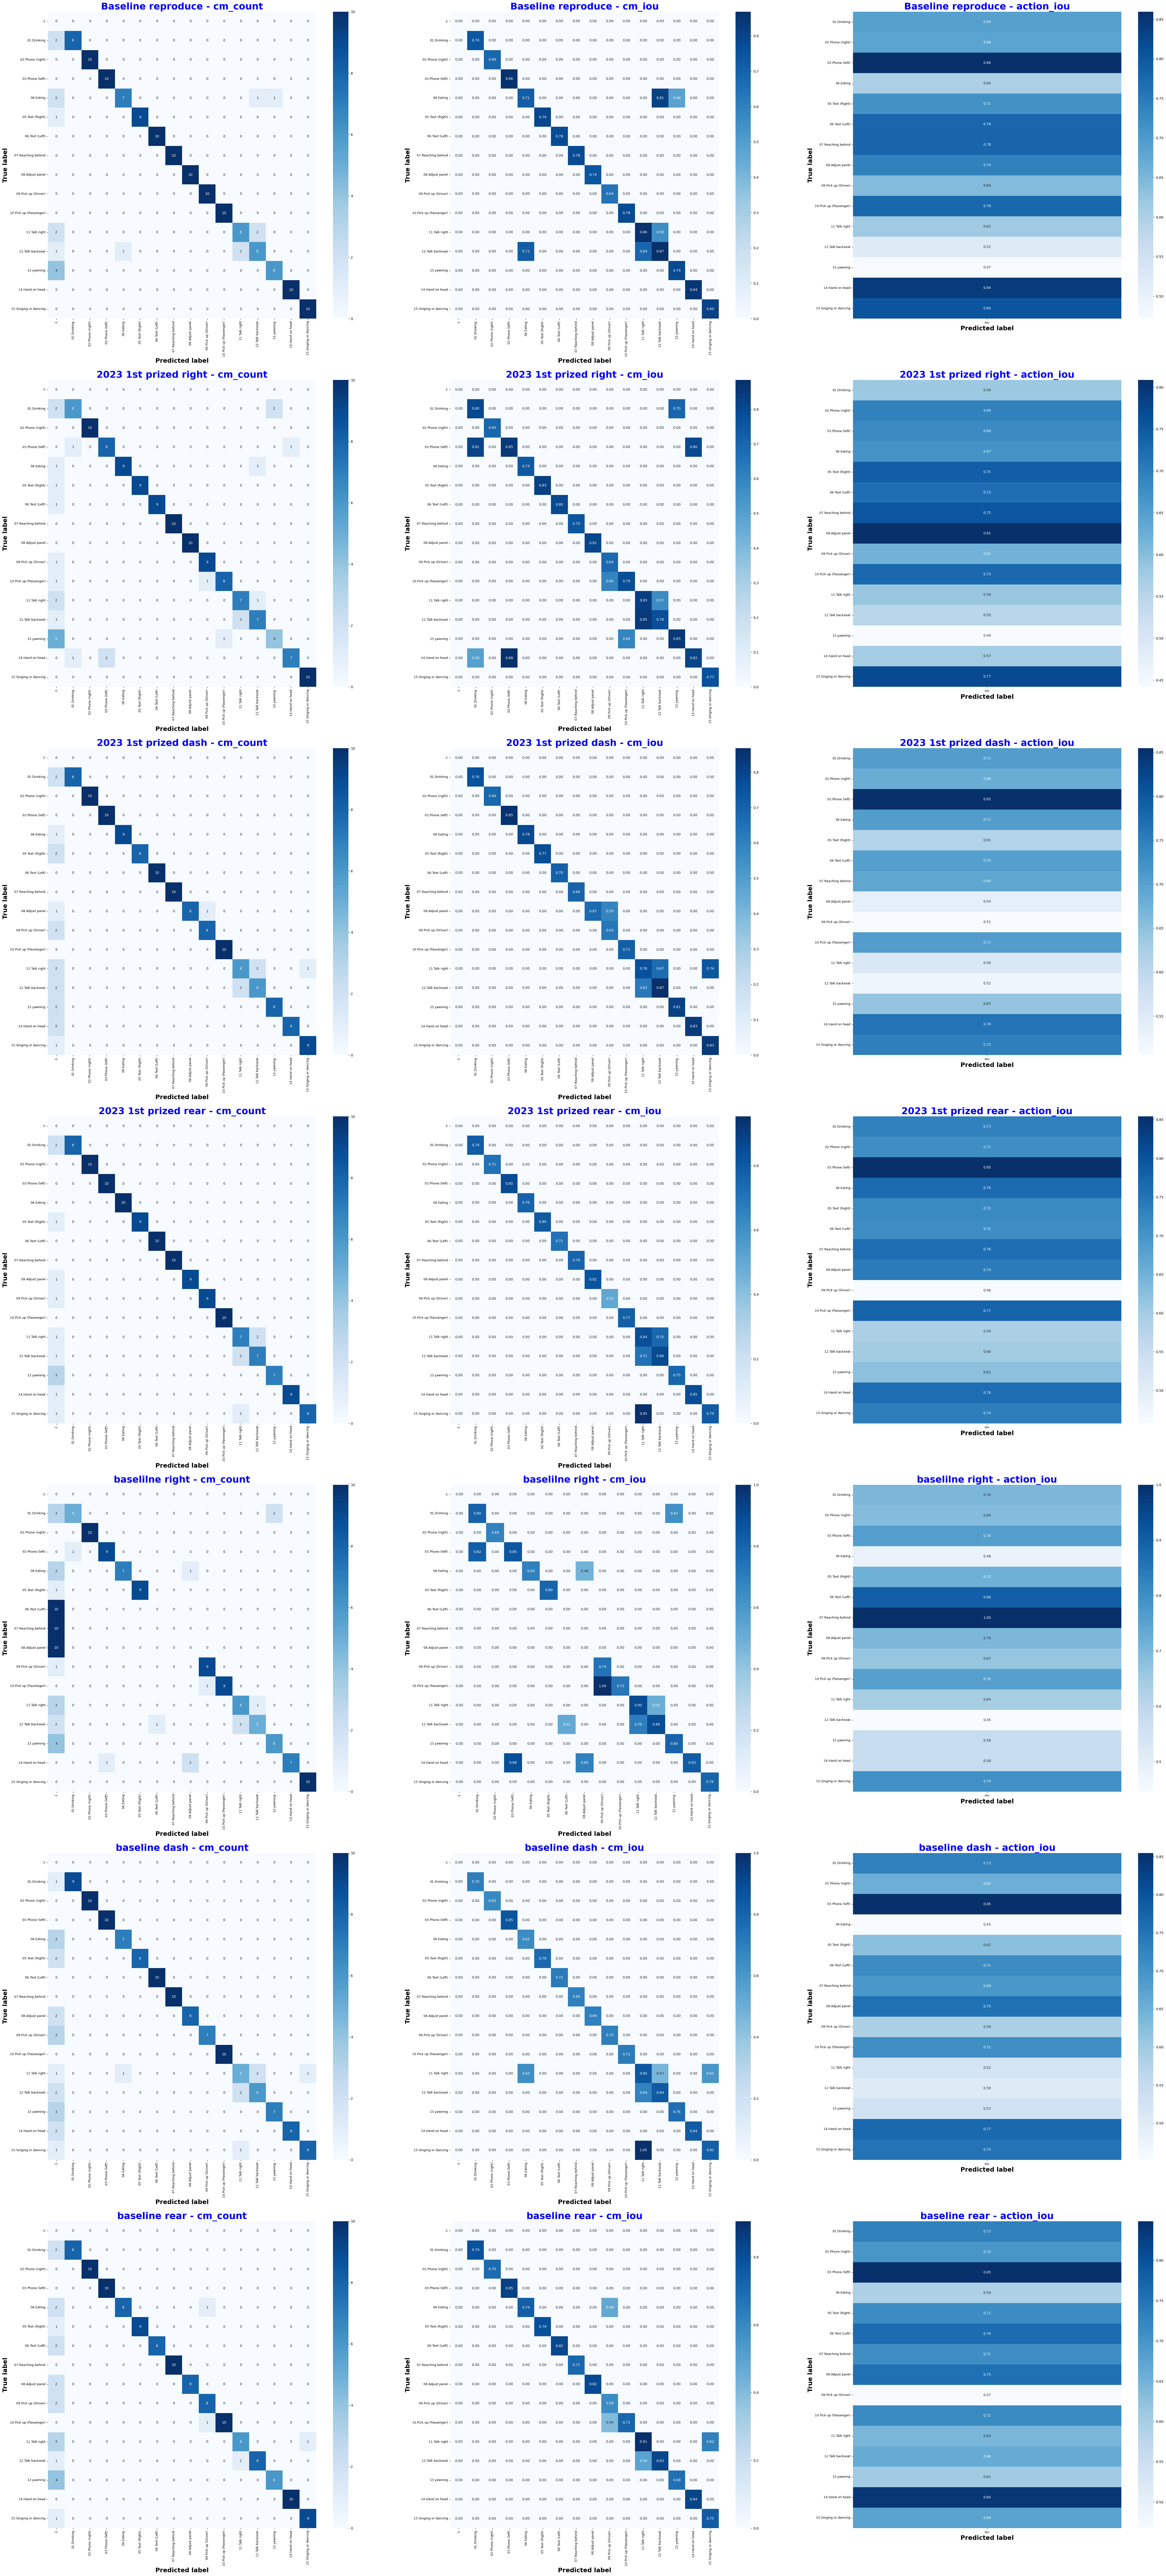

In [10]:
import warnings
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import numpy as np
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
    
# Load ground truth from Excel file
excel_file_path = 'data/A2/ground_truth_A2_manual_.xlsx'
df_ground_truth = pd.read_excel(excel_file_path,sheet_name='ground_truth_submit')

confusion_matrices_dict = {
    # '2023 1st prized': benchmark_submit(df_ground_truth,'final_submission.txt'),
    # '2023 1st prized wo buffer' : benchmark_submit(df_ground_truth,'final_submission_wo_buffer.txt'),
    # '2023 1st prized less right' : benchmark_submit(df_ground_truth,'final_submission_less_right.txt'),
    'Baseline reproduce': benchmark_submit(df_ground_truth,'A2_submission_baseline_test.txt'),
    # 'Baseline reproduce wo buffer': benchmark_submit(df_ground_truth,'A2_submission_wo_buffer.txt'),
    # 'Baseline reproduce wo buffer max': benchmark_submit(df_ground_truth,'A2_submission_wo_buffer_max.txt'),
    # 'Baseline reproduce max': benchmark_submit(df_ground_truth,'A2_submission_max.txt'),
    # 'Baseline reproduce less right': benchmark_submit(df_ground_truth,'A2_submission_test_less_right.txt'),
    # 'Baseline reproduce all avg': benchmark_submit(df_ground_truth,'A2_submission_all_avg.txt'),
    # 'Baseline reproduce all avg wo buffer': benchmark_submit(df_ground_truth,'A2_submission_all_avg_wo_buffer.txt')
    '2023 1st prized right': benchmark_submit(df_ground_truth,'final_submission_right.txt'),
    '2023 1st prized dash': benchmark_submit(df_ground_truth,'final_submission_dash.txt'),
    '2023 1st prized rear': benchmark_submit(df_ground_truth,'final_submission_rear.txt'),
    'baselilne right' : benchmark_submit(df_ground_truth,'A2_submission_baseline_right.txt'),
    'baseline dash' : benchmark_submit(df_ground_truth,'A2_submission_baseline_dash.txt'),
    'baseline rear' : benchmark_submit(df_ground_truth,'A2_submission_baseline_rear.txt')
    
}
# Plot the confusion matrices
plot_confusion_matrices(confusion_matrices_dict, size = 18)